## Байесовская линейная регрессия с библиотекой PYMC3 

В этой практике рассмотрим PYMC3 для байесовской линейной регрессии с оценкой апостериорных распределений вероятностей. 

In [135]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr

Давайте создадим некоторые переменные для нашей регрессии. Наши истинные значния:
* $\alpha = 1$
* $\sigma = 1$
* $\beta = 2.5$

Наша итоговая переменная будет расчитана по:
$$ Y = \alpha + \beta_1 X + N(0,\sigma).$$

In [136]:
# фиксируем сид
np.random.seed(42)

# Задаем значения параметров
alpha, sigma = 1, 1
beta = [2.5]

# Размер датасета
size = 1000

# Генерируем вектора признаков
X = np.random.randn(size)

# Считаем
# y_obs  = alpha + beta * X + np.random.randn(size)*sigma
y_obs = [1 if x > 1 else 0 for x in alpha + beta * X + np.random.randn(size)*sigma]

отрисовка

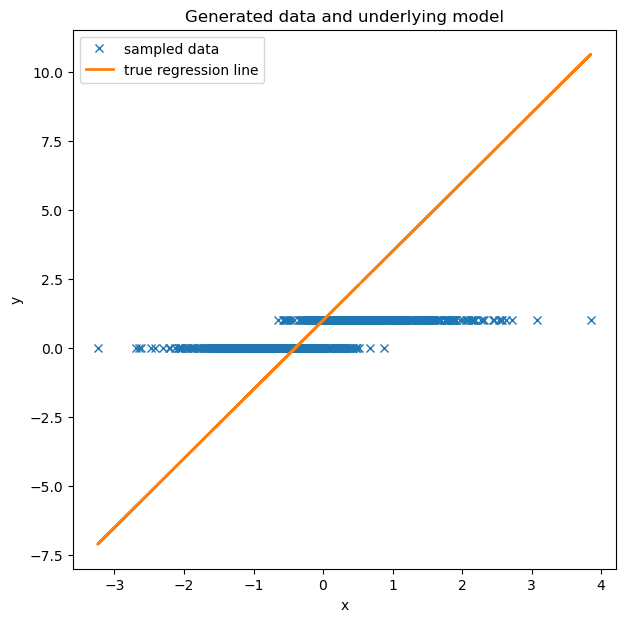

In [137]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(X, y_obs , "x", label="sampled data")
ax.plot(X, alpha + beta * X, label="true regression line", lw=2.0)
plt.legend(loc=0);

Теперь построим модель.

Априорные распределения:
* $\alpha \sim \mathcal{N}(\mu=0,\sigma=10)$
* $\beta[i] \sim \mathcal{N}(\mu=0,\sigma=10)$, where $i=1$
* $\sigma \sim \textrm{half-normal}(\sigma=1)$

Определим ожидаемое значение:
\begin{equation}
  \text{Y} = \alpha + \beta*X
\end{equation}

Байесовцы придерживаются вероятностного взгляда на мир и выражают эту модель в терминах вероятностных распределений. Нашу приведенную выше линейную регрессию можно переписать, чтобы получить:

\begin{equation}
  \text{Y}\sim \mathcal{N}(\mu=\mu,\sigma=\sigma).
\end{equation}

In [138]:
basic_model = pm.Model()

with basic_model:
    
    x = pm.MutableData("x", X)

    # Приоры для неизвестных параметров модели 
    alpha = pm.Normal('alpha', mu=0, sigma=100) #intercept
    beta = pm.Normal('beta', mu=0, sigma=100) #slope
    sigma = pm.HalfNormal('sigma', sigma=100)

    # Ожидаемое значение переменной
    # mu = alpha + beta * x
    p = pm.math.sigmoid(alpha + beta * X + sigma)

    y_model = pm.Deterministic('y_model', p)

    # Вероятность (выборочное распределение) наблюдений / Likelihood (sampling distribution) of observations
    y  = pm.Bernoulli('y', p=y_model, observed=y_obs)
    
    #   # Ожидаемое значение переменной
    # p = pm.math.sigmoid(alpha + beta * X + sigma)

    # # Вероятность (выборочное распределение) наблюдений / Likelihood (sampling distribution) of observations
    # y = pm.Bernoulli('likelihood', p, observed=Y)

    # Получаем 5000 объектов из апостериорного распределения
    idata = pm.sample(5000)
    idata.extend(pm.sample_posterior_predictive(idata))

c:\Users\User\.conda\envs\pymc_env\Lib\site-packages\pymc\data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


c:\Users\User\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 18 seconds.
c:\Users\User\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 20000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


c:\Users\User\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [139]:
basic_model

  alpha ~ Normal(0, 100)
   beta ~ Normal(0, 100)
  sigma ~ HalfNormal(0, 100)
y_model ~ Deterministic(f(sigma, alpha, beta))
      y ~ Bernoulli(y_model)
      y ~ Bernoulli(y_model)

c:\Users\User\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
c:\Users\User\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
c:\Users\User\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
c:\Users\User\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'y_model'}>,
        <Axes: title={'center': 'y_model'}>]], dtype=object)

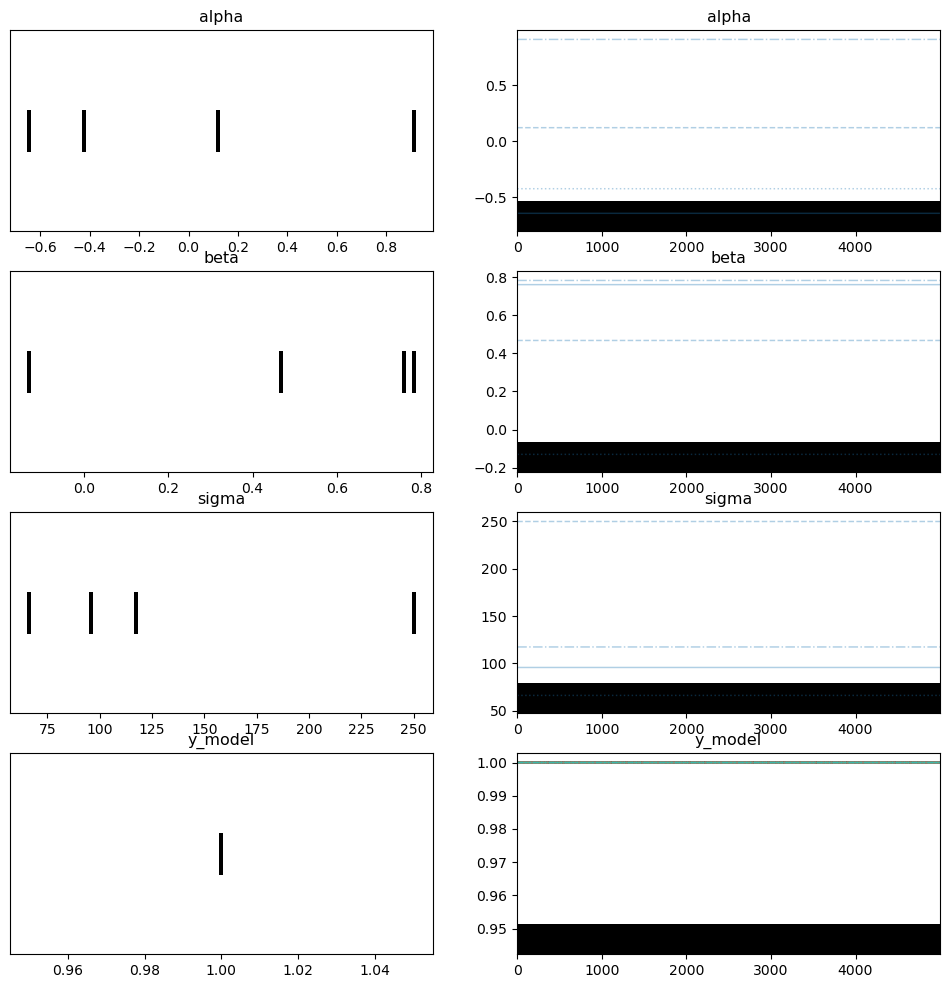

In [140]:
az.plot_trace(idata, figsize = (12, 12))

traceplot - это стандартный хороший способ просмотра апостериорных распределений вероятностей

c:\Users\User\.conda\envs\pymc_env\Lib\site-packages\arviz\plots\plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1003) in plot_posterior, generating only 40 plots
  warnings.warn(


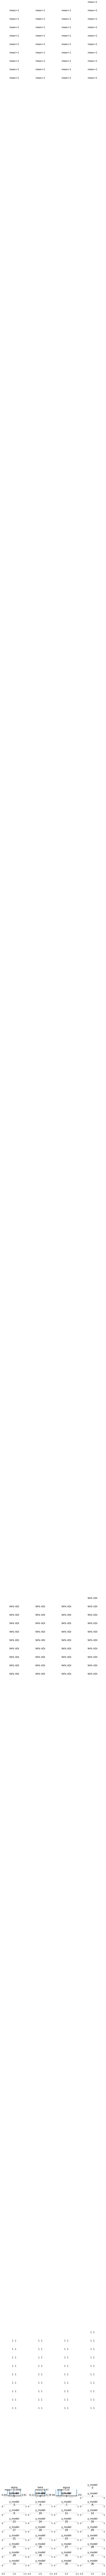

In [141]:
az.plot_posterior(idata, figsize = (12, 10), kind="hist");

Также есть встроенная функция сводки.

ValueError: x and y must have same first dimension, but have shapes (1000,) and (1,)

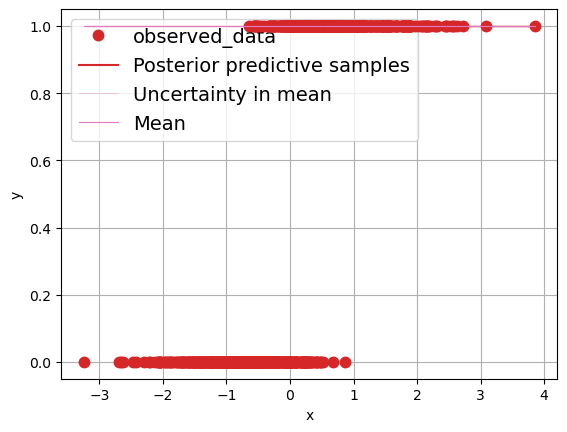

In [ ]:
# fig, axes = plt.subplots(nrows=1, figsize=(15, 15))

# plt.plot(X, y_obs, "x", label="sampled data")
# pm.plot_posterior_predictive_glm(linear_trace, samples = 100, eval=np.linspace(-2, 3, 50), linewidth = 1, 
#                                  color = 'y', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                # lm = lambda x, sample: sample['alpha'] + sample['beta'] * x);

# az.plot_lm(idata=linear_trace, num_samples = 100,  y="likelihood", axes=axes, y_model = lambda x, sample: sample['alpha'] + sample['beta'] * x);

az.plot_lm(x='x', y='y', y_model='y_model', y_hat='y', idata=idata, kind_pp='hdi');

# plt.plot(X, lambda x, sample: pm.math.sigmoid(sample['alpha'] + sample['beta'] * x), label="true regression line", lw=2.0)
plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("x")
plt.ylabel("y");

In [145]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [151]:
alpha = idata['posterior']['alpha'].mean() 
beta = idata['posterior']['beta'].mean()
print(alpha, beta)

<xarray.DataArray 'alpha' ()> Size: 8B
array(-0.00951939) <xarray.DataArray 'beta' ()> Size: 8B
array(0.46991718)


In [152]:
pm.summary(idata)

c:\Users\User\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\User\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\User\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\User\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\User\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:9

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.010,0.600,-0.645,0.910,0.300,0.130,4.0,4.0,inf
beta,0.470,0.368,-0.130,0.782,0.184,0.092,4.0,4.0,inf
sigma,132.373,70.282,66.279,249.965,35.113,19.021,4.0,4.0,inf
y_model[0],1.000,0.000,1.000,1.000,0.000,NaN,20000.0,20000.0,NaN
y_model[1],1.000,0.000,1.000,1.000,0.000,NaN,20000.0,20000.0,NaN
...,...,...,...,...,...,...,...,...,...
y_model[995],1.000,0.000,1.000,1.000,0.000,NaN,20000.0,20000.0,NaN
y_model[996],1.000,0.000,1.000,1.000,0.000,NaN,20000.0,20000.0,NaN
y_model[997],1.000,0.000,1.000,1.000,0.000,NaN,20000.0,20000.0,NaN
y_model[998],1.000,0.000,1.000,1.000,0.000,NaN,20000.0,20000.0,NaN
